Author: Carl Schneck
Program: Data Science Flex 
Phase 2 Project

# Project Title

## *****Insert Project banner image
Place banner image at top

## Contents
See phase 1 project for template

---

## Overview

A bried one-paragraph overview of the project, business problem, data, methods, results and recommendations.

## Business Understanding

Summary of the business problem we are trying to solve, and the questions that I plan to answer to solve them. (Check mvp branch to see questions to consider)


I've been presented with the task of presenting which improvements would be most beneficial to increase the sale price of a household in Washington State's King County. This will be performed by creating a linear regressin model and finding the the coefficients that have the most power.

Idea's to solve this:
1. Start with a baseline model, find the variable with the greatest correlation to sales price and create a linear
regression model.

2. Make improvements to the data to perform multi-linear regression. Scale, log etc to the variables. Remove unnecessary columns. Perform OHE to categorical variable. Perform the multilinear regression to all the variable.

3. Use recursive feature elimination to get 'best' model.

4. If this is not good enough try creating interactions between columns. repeat recursive feature elimination. Perform interactions only between objects, not themselves unless variables are clearly parabolic.

5. Test data to see if it follows the assumptions for multi linear regression.


Possible dificulties with the data that may make modeling unaccurate. House prices don't increase linearly over the years, if anything they increase exponentially. There are also outside events that cause rapid changes in prices, example housing bubble or covid. We are already not accounting for inflation, so it may be interesting to take a quick look at the dates around event like the housing bubble. (Take average sales price by year, or split the year when the bubble did pop.)

---

## Data Understanding

Describe the data being used for the project.

Where did it come from?
How does it relate to the data analysis question?
What does the data represent, who is in the sample and what variables are included.
What is the target variable?
What are the properties of the variables you intend to use?

---

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats

%matplotlib inline

## Data Preparation

Describe and justify the process for preparing the data for analysis.

In [31]:
# Load Kings county database and preview first few entries
kc_df = pd.read_csv('data/kc_house_data.csv')
kc_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [32]:
# Taking a look at all the columns, data types, and missing entries
kc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

At first glance, the columns for `id`, latitude (`lat`), and longitude (`long`) can be removed. The `id` column is good for reference, but not good for a linear regression model. The latitude and longitude appear to be difficult variables to deal with since they describe an exact location. Though in a linear regression model they will have seperate coefficients which would only be good for how far in a cordinal direction they are. Having zones like a zipcode would be preferable as that defines a region, though having a lot of zipcodes in our data set would create a lot of columns if they were treated categorically and one hot encoded. Therefore keeping the `zipcode` data will depend on how many unique values are present in this database. Another column that can be removed is the `date`, again this is good for reference, or if we would like to adjust the sales prices for inflation or other outside variables like the housing bubble in 2006. Though after some quick analysis shown below the dataset only spans the years 2014 to 2015, so the sales prices shouldn't be affected by inflation or other factors too much.

We also have to consider which columns can actually pertain to our problem. We are looking for the best variables to improve to increase the sales price. Variables like `waterfront`, `view`, `yr_built`, `yr_renovated`, `sqft_living15` and `sqft_lot15` are variables that all depend on location and can't be improved after purchase. The list below helps clarify what these columns mean.

- `waterfront`: Whether the house is on a waterfront
- `view`: Quality of view from house
- `yr_built`: Year when house was built
- `yr_renovated`: Year when the house was renovated, if applicable
- `sqft_living15`: The square footage of interior housing living space for the nearest 15 neighboors
- `sqft_lot15`: The square footage of the land lots of the nearest 15 neighbors

Considering that these variables are most likely impossible to change, they will also be ommitted from our calculations.

In [33]:
# Checking the years spanned by the data set
sales_year = kc_df.date.map(lambda x: int(x[-4:]))

print('The data spans the years {} to {}'.format(min(sales_year), max(sales_year)))
print('This is too short of a timeframe for inflation to really play a part')

The data spans the years 2014 to 2015
This is too short of a timeframe for inflation to really play a part


In [34]:
# Checking how many unique zipcodes are included in the dataset
num_of_zip = len(kc_df.zipcode.unique())
print('There are {} unique zipcodes in this data set'.format(num_of_zip))

There are 70 unique zipcodes in this data set


## Data Preparation

Describe and justify the process for preparing the data for analysis.

Having seventy unique zipcodes is a large amount. Considering that to use them we will have to one hot encode them resulting in around 69 columns after dropping one to limit multicollinearity. That amount of columns will most likely exceed to total amount of columns resulting from the rest of the data set. For simplicity the zipcode column will be dropped as well.

In [35]:
# Dropping unnecessary columns from original dataset
unn_columns = ['id', 'date', 'lat', 'long', 'zipcode', 'waterfront',
               'view', 'yr_built', 'yr_renovated', 'sqft_living15',
              'sqft_lot15']

kc_df2 = kc_df.drop(columns=unn_columns, axis=1)
kc_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   condition      21597 non-null  object 
 7   grade          21597 non-null  object 
 8   sqft_above     21597 non-null  int64  
 9   sqft_basement  21597 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 1.6+ MB


In [ ]:
'''
Initial notes on columns:

Dropable Columns: ['id', 'date', 'lat', 'long']

Missing Data or Misunderstood Data (NaN): waterfront, view, yr_renovated
**Need to research document to find more information on NaN values

Data Input: 
    Object Columns: categoricals = ['waterfront', 'view', 'condition', 'grade']
    *** Not sure yet how I want to deal with grade
    
grade: contains numeric and written classification, should get rid of written classification

yr_renovated: has both 0 and NaN inputs, look into this 

waterfront: has both no and NaN

view: has both None and NaN

Data needs to be normalized: Columns including sqft have large values, also some have zero values because they
don't exist in those homes

sqft_lots has some outliers, may need to be cut off
bedrooms has a clear outlier of 33, possibly even 10 and 11
Maybe split year built into segments and categorize them.
'''

In [10]:
df.view.value_counts(dropna=False)

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
NaN             63
Name: view, dtype: int64

In [11]:
df.waterfront.value_counts(dropna=False)

NO     19075
NaN     2376
YES      146
Name: waterfront, dtype: int64

In [12]:
df.yr_renovated.value_counts(dropna=False)

0.0       17011
NaN        3842
2014.0       73
2003.0       31
2013.0       31
          ...  
1944.0        1
1948.0        1
1976.0        1
1934.0        1
1953.0        1
Name: yr_renovated, Length: 71, dtype: int64

In [5]:
df.shape

(21597, 21)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

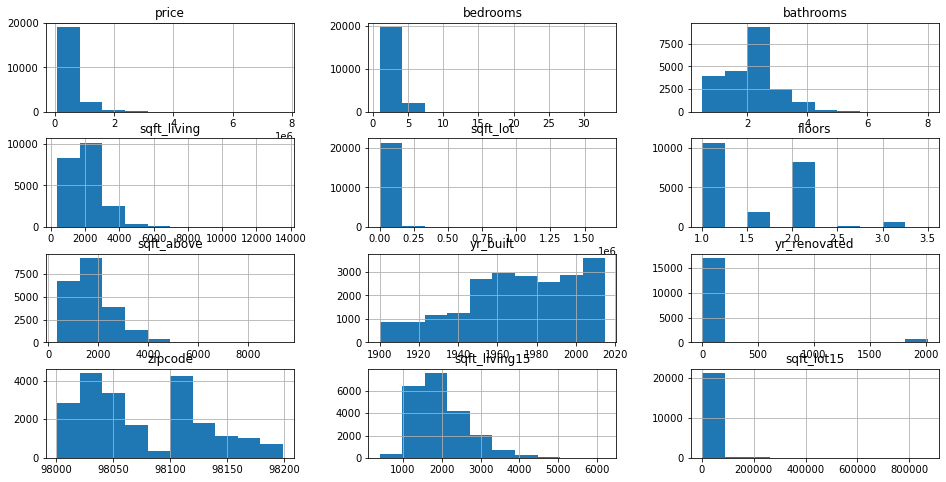

In [15]:
df2 = df.drop(columns = ['id', 'date', 'lat', 'long'], axis=1)
df2.hist(figsize = (16,8));

In [16]:
df.sqft_lot.value_counts()

5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64

In [17]:
df.bedrooms.value_counts()
# 33 bedrooms is a clear outlier

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [25]:
sorted(df.sqft_lot15.unique(), reverse=True)
# May need to have a cut off, try log function and see

[871200,
 858132,
 560617,
 438213,
 434728,
 425581,
 422967,
 411962,
 392040,
 386812,
 380279,
 360000,
 358934,
 339332,
 335289,
 326097,
 325393,
 320890,
 311610,
 310582,
 298182,
 297514,
 292645,
 291416,
 289978,
 283140,
 275299,
 273992,
 273556,
 268765,
 266587,
 263492,
 260924,
 256803,
 253519,
 248292,
 247856,
 244372,
 233971,
 233917,
 232230,
 230868,
 229996,
 229125,
 228690,
 224770,
 224334,
 223463,
 223027,
 222591,
 222156,
 221442,
 221284,
 220849,
 220654,
 220413,
 220232,
 219542,
 219229,
 219106,
 218671,
 218610,
 218235,
 218222,
 217800,
 217799,
 217790,
 217364,
 216928,
 216344,
 216057,
 215622,
 215600,
 215186,
 214315,
 213879,
 213444,
 213008,
 212137,
 211404,
 211267,
 211266,
 210830,
 210394,
 209959,
 209523,
 209088,
 208652,
 208438,
 207781,
 207206,
 207141,
 206736,
 206474,
 206038,
 205603,
 204732,
 204296,
 203425,
 202989,
 202554,
 200811,
 200527,
 199504,
 199069,
 198414,
 196591,
 195395,
 194676,
 193842,
 192268,
 

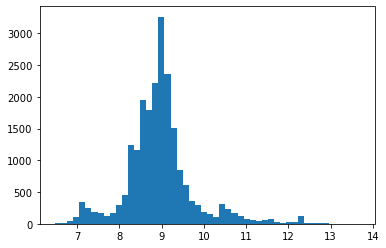

In [48]:
plt.hist(np.log(df2.sqft_lot15), bins=50);
# Appears more normal, but lets check if it works with a cutoff of 100k

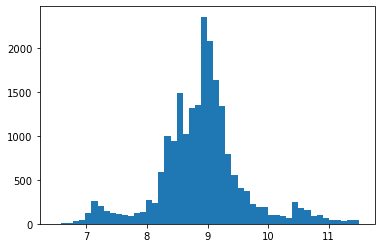

In [49]:
plt.hist(np.log(df2[df2.sqft_lot15 < 100e3].sqft_lot15), bins=50);
# appears more normal though it cuts off around 1.6% of the data

In [51]:
len(df2[df2.sqft_lot15 > 100e3])/len(df2)

0.015742927258415522

In [90]:
# Check stats for renovated homes vs non renovated homes
# Drop na values

df3 = df2.dropna(subset=['yr_renovated']).copy()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17755 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          17755 non-null  float64
 1   bedrooms       17755 non-null  int64  
 2   bathrooms      17755 non-null  float64
 3   sqft_living    17755 non-null  int64  
 4   sqft_lot       17755 non-null  int64  
 5   floors         17755 non-null  float64
 6   waterfront     15809 non-null  object 
 7   view           17704 non-null  object 
 8   condition      17755 non-null  object 
 9   grade          17755 non-null  object 
 10  sqft_above     17755 non-null  int64  
 11  sqft_basement  17755 non-null  object 
 12  yr_built       17755 non-null  int64  
 13  yr_renovated   17755 non-null  float64
 14  zipcode        17755 non-null  int64  
 15  sqft_living15  17755 non-null  int64  
 16  sqft_lot15     17755 non-null  int64  
dtypes: float64(4), int64(8), object(5)
memory usage: 2

In [91]:
# Interested in grade and condition, so lets make those columns numeric
df3.grade.value_counts()

7 Average        7362
8 Good           4985
9 Better         2176
6 Low Average    1681
10 Very Good      933
11 Excellent      326
5 Fair            190
12 Luxury          72
4 Low              18
13 Mansion         11
3 Poor              1
Name: grade, dtype: int64

In [92]:
df3.condition.value_counts()

Average      11525
Good          4646
Very Good     1417
Fair           144
Poor            23
Name: condition, dtype: int64

In [93]:
asdf = '7 Average'
int(asdf[:2])

7

In [94]:
def grade_change(ds):
    return int(ds[:2])

condition_map = {'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}

In [95]:
df3.grade = df3.grade.map(grade_change)

In [98]:
df3.grade.value_counts()

7     7362
8     4985
9     2176
6     1681
10     933
11     326
5      190
12      72
4       18
13      11
3        1
Name: grade, dtype: int64

In [99]:
df3.condition = df3.condition.map(condition_map)
df3.condition.value_counts()

3    11525
4     4646
5     1417
2      144
1       23
Name: condition, dtype: int64

In [100]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17755 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          17755 non-null  float64
 1   bedrooms       17755 non-null  int64  
 2   bathrooms      17755 non-null  float64
 3   sqft_living    17755 non-null  int64  
 4   sqft_lot       17755 non-null  int64  
 5   floors         17755 non-null  float64
 6   waterfront     15809 non-null  object 
 7   view           17704 non-null  object 
 8   condition      17755 non-null  int64  
 9   grade          17755 non-null  int64  
 10  sqft_above     17755 non-null  int64  
 11  sqft_basement  17755 non-null  object 
 12  yr_built       17755 non-null  int64  
 13  yr_renovated   17755 non-null  float64
 14  zipcode        17755 non-null  int64  
 15  sqft_living15  17755 non-null  int64  
 16  sqft_lot15     17755 non-null  int64  
dtypes: float64(4), int64(10), object(3)
memory usage: 

In [102]:
# Split into groups of renovated and not renovated
df_renovated = df3[df3.yr_renovated > 0]
df_nrenovated = df3[df3.yr_renovated == 0]

In [103]:
df_renovated.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
count,7.440000e+02,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000
mean,7.689019e+05,3.459677,2.306116,2327.377688,16215.530914,1.504704,3.219086,7.752688,1878.719086,1939.455645,1995.928763,98095.623656,1988.877688,13390.768817
std,6.271258e+05,1.068823,0.898233,1089.002040,38235.308760,0.493202,0.520494,1.196954,849.441413,22.088850,15.599946,54.861316,715.440144,26213.648057
min,1.100000e+05,1.000000,0.750000,520.000000,1024.000000,1.000000,1.000000,4.000000,520.000000,1900.000000,1934.000000,98001.000000,828.000000,1281.000000
25%,4.122500e+05,3.000000,1.750000,1560.000000,5000.000000,1.000000,3.000000,7.000000,1267.500000,1921.000000,1987.000000,98040.000000,1460.000000,5000.000000
50%,6.075020e+05,3.000000,2.250000,2200.000000,7375.000000,1.500000,3.000000,8.000000,1730.000000,1941.500000,2000.000000,98112.000000,1850.000000,7455.000000
75%,9.000000e+05,4.000000,2.750000,2872.500000,12670.750000,2.000000,3.000000,8.000000,2300.000000,1955.000000,2007.250000,98126.000000,2380.000000,10925.750000
max,7.700000e+06,11.000000,8.000000,12050.000000,478288.000000,3.000000,5.000000,13.000000,8570.000000,2003.000000,2015.000000,98199.000000,5500.000000,310582.000000


In [104]:
df_nrenovated.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
count,1.701100e+04,17011.000000,17011.000000,17011.000000,1.701100e+04,17011.000000,17011.000000,17011.000000,17011.000000,17011.000000,17011.0,17011.000000,17011.000000,17011.000000
mean,5.306775e+05,3.374934,2.112398,2073.659279,1.524147e+04,1.495444,3.418964,7.657633,1787.751102,1972.492328,0.0,98076.984833,1989.954089,12843.540239
std,3.504157e+05,0.926286,0.760386,907.913731,4.227023e+04,0.540369,0.656315,1.169725,825.496535,28.848231,0.0,53.291531,683.581726,27786.030994
min,8.000000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1.000000,3.000000,370.000000,1900.000000,0.0,98001.000000,399.000000,659.000000
25%,3.200000e+05,3.000000,1.750000,1421.000000,5.054500e+03,1.000000,3.000000,7.000000,1190.000000,1954.000000,0.0,98032.000000,1490.000000,5100.000000
50%,4.475000e+05,3.000000,2.250000,1910.000000,7.616000e+03,1.500000,3.000000,7.000000,1560.000000,1977.000000,0.0,98065.000000,1840.000000,7621.000000
75%,6.344000e+05,4.000000,2.500000,2540.000000,1.062150e+04,2.000000,4.000000,8.000000,2210.000000,1998.000000,0.0,98117.000000,2370.000000,10072.500000
max,6.890000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,2015.000000,0.0,98199.000000,6210.000000,871200.000000


In [112]:
# Let's make a quick scatter plot showing yr_built and price, with a hue of whether the house was renovated or not
df_renovated.loc[:, 'renovated'] = 'Yes'
df_nrenovated.loc[:, 'renovated'] = 'No'
df3 = pd.concat([df_renovated, df_nrenovated])

In [113]:
df3.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,renovated
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,3,7,2170,400.0,1951,1991.0,98125,1690,7639,Yes
35,696000.0,3,2.50,2300,3060,1.5,NO,NONE,3,8,1510,790.0,1930,2002.0,98115,1590,3264,Yes
95,905000.0,4,2.50,3300,10250,1.0,NO,NONE,3,7,2390,910.0,1946,1991.0,98040,1950,6045,Yes
103,1090000.0,3,2.50,2920,8113,2.0,NO,NONE,3,8,2920,0.0,1950,2010.0,98004,2370,8113,Yes
125,1450000.0,4,2.75,2750,17789,1.5,NO,NONE,3,8,1980,770.0,1914,1992.0,98004,3060,11275,Yes


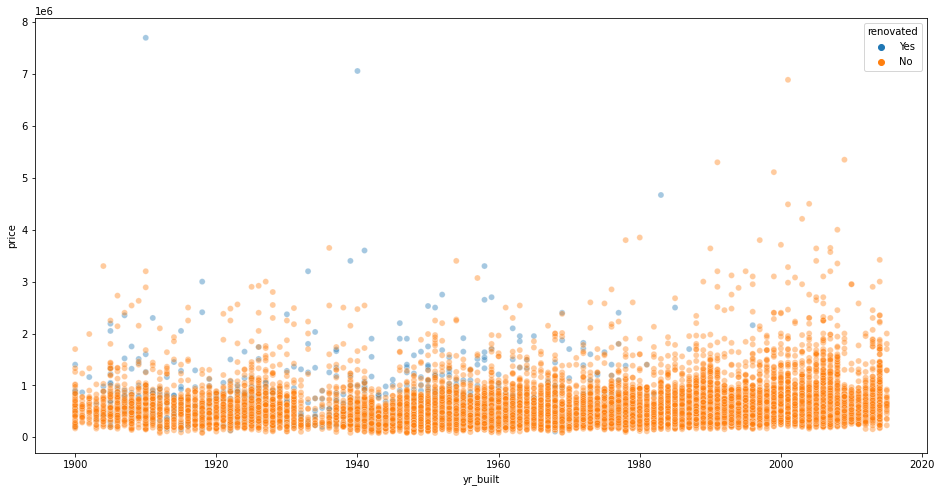

In [120]:
fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(data=df3, x='yr_built', y='price', hue='renovated', alpha=.4, ax=ax);

In [122]:
# Figure was hard to see so lets check out on average by year
a = df3.groupby(['yr_built', 'renovated']).mean().reset_index()

,yr_built,renovated,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,1900,No,580907.000000,3.245614,1.605263,1654.421053,5749.473684,1.491228,3.596491,6.771930,1487.578947,0.000000,98106.596491,1689.368421,6305.035088
1,1900,Yes,609846.153846,3.538462,2.211538,1955.384615,21119.846154,1.653846,3.384615,7.307692,1507.692308,1992.923077,98095.692308,1835.384615,11153.461538
2,1901,No,547051.909091,3.272727,1.534091,1692.045455,4042.363636,1.590909,3.818182,7.045455,1474.318182,0.000000,98123.500000,1520.818182,3935.181818
3,1901,Yes,865000.000000,4.000000,2.000000,2750.000000,5527.000000,2.000000,3.000000,8.000000,2130.000000,1987.000000,98119.000000,1290.000000,1764.000000
4,1902,No,676660.000000,3.450000,1.875000,1941.500000,4351.100000,1.750000,3.700000,7.350000,1768.500000,0.000000,98117.500000,1819.000000,4311.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2011,No,549814.190476,3.495238,2.659524,2348.838095,6567.876190,2.009524,3.000000,8.219048,2202.980952,0.000000,98060.657143,2261.933333,5980.990476
205,2012,No,526887.228571,3.578571,2.617857,2376.178571,6371.692857,1.985714,3.000000,8.200000,2283.392857,0.000000,98065.192857,2244.171429,6013.778571
206,2013,No,671520.260355,3.846154,2.846154,2623.822485,7180.556213,2.041420,3.000000,8.479290,2441.869822,0.000000,98067.011834,2322.094675,7885.479290
207,2014,No,684410.525164,3.741794,2.756565,2625.070022,5762.000000,2.117068,3.000000,8.555799,2443.689278,0.000000,98075.844639,2280.299781,6246.096280


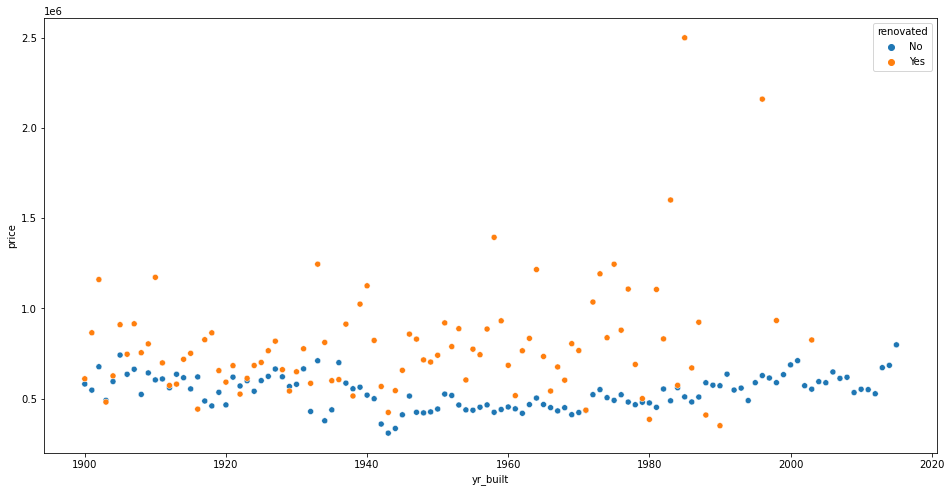

In [124]:
fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(data=a, x='yr_built', y='price', hue='renovated', ax=ax);

In [105]:
df2.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.585241,0.082845
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,0.393406,0.030690
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.569884,0.088303
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.756402,0.184342
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,0.144763,0.718204
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.280102,-0.010722
sqft_above,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,0.731767,0.195077
yr_built,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,0.326377,0.070777
yr_renovated,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,-0.000247,0.003852
zipcode,-0.053402,-0.154092,-0.204786,-0.199802,-0.129586,-0.059541,-0.261570,-0.347210,0.069846,1.000000,-0.279299,-0.147294


In [106]:
len(df.zipcode.unique())

70

## Modeling

---

## Evaluation

---

## Conclusion

---

## Appendix
Extra Figures??

---

## Resources

Any Works Cited

---